<a href="https://colab.research.google.com/github/Boska-Sony-507/Medical-Imge-Super-Resolution-using-GANs/blob/main/GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
# Define dataset path
dataset_path = "/content/drive/MyDrive/miniproject/yes/"

# Verify dataset
print(os.listdir(dataset_path))


['Y120.JPG', 'Y101.jpg', 'Y1.jpg', 'Y117.JPG', 'Y10.jpg', 'Y103.jpg', 'Y105.jpg', 'Y11.jpg', 'Y111.JPG', 'Y104.jpg', 'Y112.JPG', 'Y108.jpg', 'Y12.jpg', 'Y116.JPG', 'Y114.JPG', 'Y106.jpg', 'Y115.JPG', 'Y109.JPG', 'Y100.JPG', 'Y113.JPG', 'Y102.jpg', 'Y107.jpg', 'Y13.jpg', 'Y184.JPG', 'Y14.jpg', 'Y160.JPG', 'Y16.JPG', 'Y18.JPG', 'Y17.jpg', 'Y169.jpg', 'Y167.JPG', 'Y156.JPG', 'Y187.jpg', 'Y166.JPG', 'Y15.jpg', 'Y180.jpg', 'Y146.JPG', 'Y158.JPG', 'Y183.jpg', 'Y181.jpg', 'Y155.JPG', 'Y153.jpg', 'Y165.JPG', 'Y185.jpg', 'Y148.JPG', 'Y164.JPG', 'Y186.jpg', 'Y168.jpg', 'Y147.JPG', 'Y161.JPG', 'Y154.jpg', 'Y159.JPG', 'Y157.JPG', 'Y162.jpg', 'Y182.JPG', 'Y163.JPG', 'Y170.JPG', 'Y250.jpg', 'Y254.jpg', 'Y253.JPG', 'Y188.jpg', 'Y26.jpg', 'Y25.jpg', 'Y251.JPG', 'Y22.jpg', 'Y257.jpg', 'Y245.jpg', 'Y244.JPG', 'Y255.JPG', 'Y2.jpg', 'Y256.JPG', 'Y195.JPG', 'Y19.JPG', 'Y249.JPG', 'Y192.JPG', 'Y193.JPG', 'Y242.JPG', 'Y248.JPG', 'Y20.jpg', 'Y247.JPG', 'Y243.JPG', 'Y21.jpg', 'Y259.JPG', 'Y252.jpg', 'Y246.JPG'

In [ ]:
# Function to load dataset
def load_dataset():
    lr_data = []  # Low-resolution images
    hr_data = []  # High-resolution images
    for img_path in os.listdir(dataset_path):
        hr_img = tf.keras.preprocessing.image.load_img(dataset_path + img_path, color_mode="grayscale", target_size=(128, 128))
        hr_img = tf.keras.preprocessing.image.img_to_array(hr_img) / 255.0  # Normalize
        hr_data.append(hr_img)

        lr_img = tf.image.resize(hr_img, (64, 64))
        lr_data.append(lr_img)

    return tf.convert_to_tensor(lr_data), tf.convert_to_tensor(hr_data)


In [ ]:
# Load dataset
lr_dataset, hr_dataset = load_dataset()
print("Low-Resolution Dataset shape:", lr_dataset.shape)
print("High-Resolution Dataset shape:", hr_dataset.shape)

Low-Resolution Dataset shape: (155, 64, 64, 1)
High-Resolution Dataset shape: (155, 128, 128, 1)


In [ ]:
def build_generator():
    inputs = tf.keras.Input(shape=(64, 64, 1))

    x = UpSampling2D(size=2)(inputs)  # Upsample to 128x128
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(x)

    return Model(inputs, x)

In [ ]:
# Discriminator Model
def build_discriminator():
    inputs = tf.keras.Input(shape=(128, 128, 1))

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs, x)

In [ ]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
real_pred = discriminator.predict(hr_dataset)
fake_pred = discriminator.predict(generator.predict(lr_dataset))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


In [ ]:
print(f"Discriminator output for real image: {real_pred[0][0]:.4f} → {'Real' if real_pred[0][0] > 0.5 else 'Fake'}")
print(f"Discriminator output for generated image: {fake_pred[0][0]:.4f} → {'Real' if fake_pred[0][0] > 0.3 else 'Fake'}")


Discriminator output for real image: 0.5133 → Real
Discriminator output for generated image: 0.5153 → Real


In [ ]:
def build_srgan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator when training the generator

    inputs = tf.keras.Input(shape=(64, 64, 1))  # HR Image

    generated_hr = generator(inputs)  # Generate sR Image
    validity = discriminator(generated_hr)

    return Model(inputs, [generated_hr, validity], name="SRGAN")


In [ ]:
# Compile models
generator.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4))

In [ ]:
# Training loop
import tensorflow as tf
epochs = 10
batch_size = 16

for epoch in range(epochs):
    idx = tf.random.uniform(shape=[batch_size], minval=0, maxval=lr_dataset.shape[0], dtype=tf.int32) # Generate random indices as a TensorFlow tensor
    lr_imgs = tf.gather(lr_dataset, idx) # Select elements from lr_dataset using tf.gather
    hr_imgs = tf.gather(hr_dataset, idx) # Select elements from hr_dataset using tf.gather

    sr_imgs = generator.predict(lr_imgs)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(hr_imgs, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(sr_imgs, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    g_loss = generator.train_on_batch(lr_imgs, hr_imgs)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss:.4f} - G Loss: {g_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 0/10 - D Loss: 0.7149 - G Loss: 0.1319
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


In [ ]:
# Function to evaluate PSNR and SSIM
def evaluate_model(generator, lr_images, hr_images, num_samples=10):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        lr_img = lr_images[i].numpy()
        hr_img = hr_images[i].numpy()
        sr_img = generator.predict(np.expand_dims(lr_img, axis=0))[0]

        psnr_value = psnr(hr_img, sr_img, data_range=230.0)
        ssim_value = ssim(hr_img.squeeze(), sr_img.squeeze(), data_range=230.0)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    print(f"Average PSNR:{np.mean(psnr_values):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_values):.4f}")

In [ ]:
# Call evaluation function
evaluate_model(generator, lr_dataset[:10], hr_dataset[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Average PSNR:57.35 dB
Average SSIM: 0.9878


In [ ]:
# Function to display results
def display_results(generator, lr_images, hr_images, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        lr_img = lr_images[i].numpy()
        hr_img = hr_images[i].numpy()
        sr_img = generator.predict(np.expand_dims(lr_img, axis=0))[0]

        # Plot Low-Resolution Image
        axes[i, 0].imshow(lr_img.squeeze(), cmap="gray")
        axes[i, 0].set_title("Low-Resolution")
        axes[i, 0].axis("off")

        # Plot High-Resolution Image
        axes[i, 2].imshow(hr_img.squeeze(), cmap="gray")
        axes[i, 2].set_title("Super-Resolution (SRGAN)")
        axes[i, 2].axis("off")

        # Plot Super-Resolved Image
        axes[i, 1].imshow(sr_img.squeeze(), cmap="gray")
        axes[i, 1].set_title("High-Resolution")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


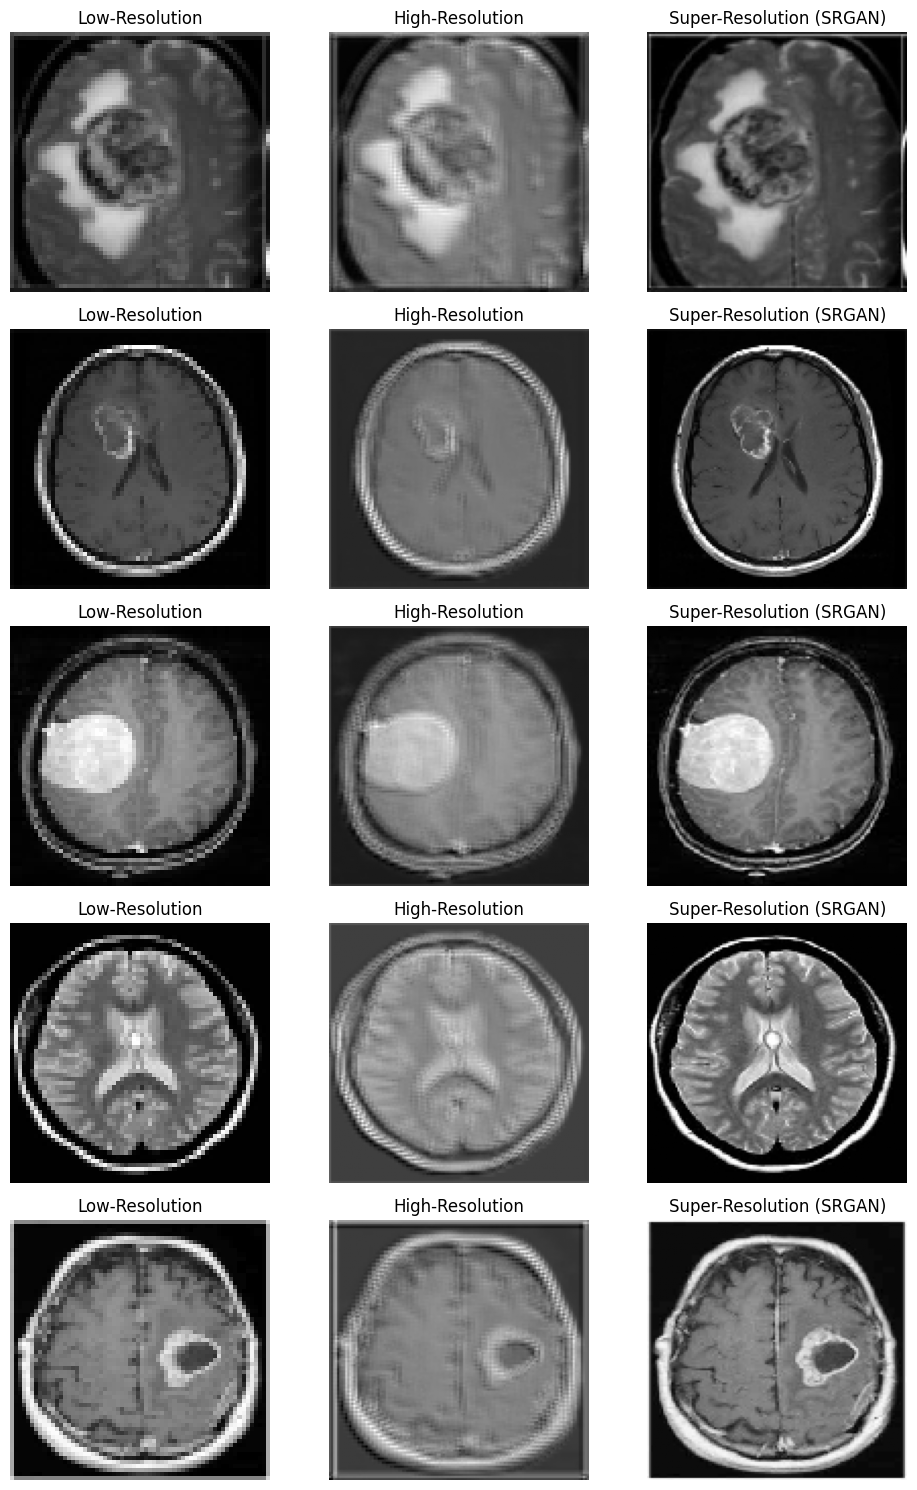

In [ ]:
# Display results
display_results(generator, lr_dataset[:5], hr_dataset[:5])